# Install conda on your Colab environment

Ignore this first cell if you are running the notebook in a local environment.

One can still run it locally but it will have no effect.

In [1]:
# Run this cell first - it will install a conda distribution (mamba)
# on your Drive then restart the kernel automatically 
# (don't worry about the crashing/restarting kernel messages)
# It HAS to be runned FIRST everytime you use the notebook in colab

import os
import sys
RunningInCOLAB  = 'google.colab' in str(get_ipython())

if RunningInCOLAB:
    !pip install -q condacolab
    import condacolab
    condacolab.install()

# Set up your Colab or local environment
# Then import libraries

Run this cell in both cases of use (local or Colab)

In [1]:
import os
import sys
RunningInCOLAB  = 'google.colab' in str(get_ipython())

if RunningInCOLAB:
    
    # Check everything is fine with conda in Colab
    import condacolab
    condacolab.check()
    
    # Mount your drive environment in the colab runtime
    from google.colab import drive
    drive.mount('/content/drive',force_remount=True)
    
    # Change this variable to your path on Google Drive to which the repo has been cloned
    # If you followed the colab notebook 'repo_cloning.ipynb', nothing to change here
    repo_path_in_drive = '/content/drive/My Drive/Github/amn_release/'
    # Change directory to your repo cloned in your drive
    DIRECTORY = repo_path_in_drive
    os.chdir(repo_path_in_drive)
    # Copy the environment given in the environment_amn_light.yml
    !mamba env update -n base -f environment_amn_light.yml
    
    # This is one of the few Colab-compatible font
    font = 'Liberation Sans'
    
else:
    
    # In this case the local root of the repo is our working directory
    DIRECTORY = './'
    font = 'arial'

# printing the working directory files. One can check you see the same folders and files as in the git webpage.
print(os.listdir(DIRECTORY))

from Library.Build_Dataset_KO import *

['README.md', 'Duplicate_Model.ipynb', 'Dataset_experimental', 'Tutorial.ipynb', '.ipynb_checkpoints', '.git', 'Build_Model_RC.ipynb', 'Build_Model_AMN_KO.ipynb', 'biolog_simulations.npy', 'environment_amn_light.yml', 'Build_Experimental.ipynb', 'Reservoir', 'Build_Model_MM.ipynb', 'Dataset_model', 'Figures.ipynb', 'Result', 'Figures', '.gitignore', 'LICENSE', 'Build_Model_ANN_Dense.ipynb', 'Build_Dataset.ipynb', 'Library', 'Dataset_input', 'Functions', 'Build_Dataset_KO.ipynb', 'environment_amn.yml', 'Build_Model_AMN.ipynb', '.DS_Store']


# Generate Training Sets with FBA simulation or experimental data file



Below are provided several examples to generate training sets using different metabolic models, or experimental datafiles.

We also provide a way to run cobrapy with provided inputs, such as the reservoir computing predictions (see figure 5 of the research paper).

## Examples of experimental or manual training set generation

This cell provides a way to generate a training set with the same object (parameter) as simulated training sets using Cobra, but only using the experimental data. In this cell, we do not run cobra to generate the training set but instead directly use the experimental data.

In [3]:
# Generate training set from experimental file (E. coli biolog with gene KOs, ASAP database) for iML1515

# What you can change
seed = 10
np.random.seed(seed=seed)  # seed for random number generator
cobraname = 'iML1515_duplicated'  # name of the model
mediumbound = 'UB' # a must exact bounds unknown
mediumname = 'biolog_iML1515_EXP' # name of experimental file
method = 'EXP' # FBA, pFBA or EXP
reduce = False # Set at True if you want to reduce the model
# End of What you can change

# Get data
cobrafile = DIRECTORY+'Dataset_input/'+cobraname
mediumfile  = DIRECTORY+'Dataset_input/'+mediumname
parameter = TrainingSet(cobraname=cobrafile, 
                        mediumname=mediumfile, mediumbound=mediumbound, mediumsize=430, 
                        method=method,verbose=False)

# Saving file
trainingfile  = DIRECTORY+'Dataset_model/'+mediumname+'_'+parameter.mediumbound
print("Saving...")
parameter.save(trainingfile, no_matrices_LP=True, reduce=reduce)
# With this dataset, the generation of LP matrices is prohibitive.
# Due to high number of possible exchange reactions, the row_echelon as it is encoded cannot work.

# Verifying
parameter = TrainingSet()
parameter.load(trainingfile)
print("Re-loading...")
parameter.printout()

Saving...
Re-loading...
model file name: ./Dataset_model/biolog_iML1515_EXP_UB
reduced model: False
medium file name: ./Dataset_input/biolog_iML1515_EXP
medium bound: UB
list of reactions in objective: ['BIOMASS_Ec_iML1515_core_75p37M']
method: EXP
trainingsize: 17400
list of medium reactions: 430
list of medium levels: 0
list of medium values: 0
ratio of variable medium turned on: 0
list of measured reactions: 3682
Stoichiometric matrix (1877, 3682)
Boundary matrix from reactions to medium: (430, 3682)
Measurement matrix from reaction to measures: (3682, 3682)
Reaction to metabolite matrix: (1877, 3682)
Metabolite to reaction matrix: (3682, 1877)
Training set X: (17400, 430)
Training set Y: (17400, 1)
list of genes targeted: 0
Training set X for genes: (1, 1)
S_int matrix ()
S_ext matrix ()
Q matrix ()
P matrix ()
b_int vector ()
b_ext vector ()
Sb matrix ()
c vector ()


## Running Cobra on a provided dataset set

This cell has a completely different purpose than the rest of the notebook. It serves as a cell running Cobrapy with  provided values as inputs. These inputs are extracted from Reservoir Computing, you can see an example in the notebook `Build_Model_RC.ipynb`

In [4]:
# This cell run FBA on a provided dataset and compute R2 between
# provided objective and calculated objective
# R2 = 1 when the training set was generated by FBA, but may be different than 1
# when the training set is an experimental one
# For experimental training set medium input fluxes can be scaled by a value

from sklearn.metrics import r2_score

# What you can change 
seed = 10
np.random.seed(seed=seed)
mediumname = 'biolog_iML1515_EXP_UB' # for running Cobra with RC predictions as inputs
# End of What you can change

# Get data
trainingfile = DIRECTORY+'Dataset_model/'+mediumname
parameter = TrainingSet()
parameter.load(trainingfile)
print("Re-loading...")
parameter.printout()
scaler_list = [21] # test different scalers

# regression cobra vs. true values
L = parameter.X.shape[0]

all_res = []

for scaler in scaler_list:
    Y = {}
    for i in range(L):
        inf = {r: 0 for r in parameter.medium}
        for j in range(len(parameter.medium)):
            #print(j, parameter.medium[j],parameter.X[i,j], len(parameter.model.reactions))
            eps = 1.0e-4 if parameter.X[i,j] < 1.0e-4 else 0
            inf[parameter.medium[j]] = scaler * parameter.X[i,j] + eps

        # print(inf)
        out,Y[i] = run_cobra(parameter.model, parameter.objective, inf, method='pFBA', verbose=False)
        # print(parameter.Y[i], Y[i])
        print("%d %.4f %.4f" % (i, parameter.Y[i], Y[i]))

    Y = list(Y.values())
    r2 = r2_score(parameter.Y[0:L], Y[0:L], multioutput='variance_weighted')

    all_res.append((Y, r2))
    print('scaler %.2f R2 %.4f ' % (scaler, r2))

Re-loading...
model file name: ./Dataset_model/biolog_iML1515_EXP_UB
reduced model: False
medium file name: ./Dataset_input/biolog_iML1515_EXP
medium bound: UB
list of reactions in objective: ['BIOMASS_Ec_iML1515_core_75p37M']
method: EXP
trainingsize: 17400
list of medium reactions: 430
list of medium levels: 0
list of medium values: 0
ratio of variable medium turned on: 0
list of measured reactions: 3682
Stoichiometric matrix (1877, 3682)
Boundary matrix from reactions to medium: (430, 3682)
Measurement matrix from reaction to measures: (3682, 3682)
Reaction to metabolite matrix: (1877, 3682)
Metabolite to reaction matrix: (3682, 1877)
Training set X: (17400, 430)
Training set Y: (17400, 1)
list of genes targeted: 0
Training set X for genes: (1, 1)
S_int matrix ()
S_ext matrix ()
Q matrix ()
P matrix ()
b_int vector ()
b_ext vector ()
Sb matrix ()
c vector ()
0 0.7800 0.0000
1 1.4300 0.0000
2 1.0400 0.0000
3 1.0900 0.0000
4 0.9100 0.0000
5 0.1200 0.0000
6 0.8900 0.0000
7 0.9900 0.000

KeyboardInterrupt: 

/home/lfaure/miniconda3/envs/AMN/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


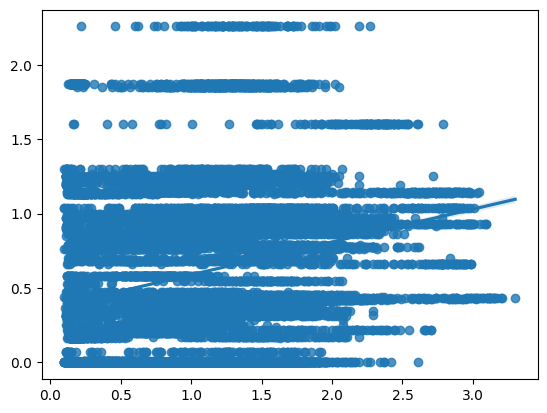

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(palette="colorblind", font_scale=50)
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.regplot(parameter.Y, all_res[0][0], fit_reg=0, marker='.')
sns.lineplot([min(parameter.Y.ravel()), max(parameter.Y.ravel())], [min(parameter.Y.ravel()), max(parameter.Y.ravel())], color='y')
plt.savefig("RegPerf_cobra.png")